# Лабораторная работа № 5 по дисциплине "Системы искусственного интеллекта"

## Задание лабораторной работы

0. Использовать [датасет с данными про оценки студентов инженерного и педагогического факультетов](https://archive.ics.uci.edu/dataset/856/higher+education+students+performance+evaluation) (для данного датасета нужно ввести метрику: студент успешный/неуспешный на основании грейда)
1. Отобрать **случайным** образом sqrt(n) признаков
2. Реализовать без использования сторонних библиотек построение дерева решений  (дерево не бинарное, numpy и pandas использовать можно, использовать список списков  для реализации  дерева - нельзя) для решения задачи бинарной классификации 
3. Провести оценку реализованного алгоритма с использованием Accuracy, precision и recall
4. Построить кривые AUC-ROC и AUC-PR (в пунктах 3 и 4 использовать библиотеки нельзя)
  - а можно хотя бы `matplotlib`? :blush:

## Выполнение лабораторной работы
### 0. Установка и импорт библиотек, загрузка датасета

Сначала установим библиотеки, если они уже не установлены.

In [637]:
!pip install numpy pandas matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Импортируем необходимые библиотеки.

In [638]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Клонируем датасет.

In [639]:
data = pd.read_csv('../datasets/DATA (1).csv')
print(type(data))
print(data)
print(data.describe())
data.head()

<class 'pandas.core.frame.DataFrame'>
     STUDENT ID  1  2  3  4  5  6  7  8  9  ...  23  24  25  26  27  28  29  \
0      STUDENT1  2  2  3  3  1  2  2  1  1  ...   1   1   3   2   1   2   1   
1      STUDENT2  2  2  3  3  1  2  2  1  1  ...   1   1   3   2   3   2   2   
2      STUDENT3  2  2  2  3  2  2  2  2  4  ...   1   1   2   2   1   1   2   
3      STUDENT4  1  1  1  3  1  2  1  2  1  ...   1   2   3   2   2   1   3   
4      STUDENT5  2  2  1  3  2  2  1  3  1  ...   2   1   2   2   2   1   2   
..          ... .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..   
140  STUDENT141  2  1  2  3  1  1  2  1  1  ...   1   1   2   1   2   1   3   
141  STUDENT142  1  1  2  4  2  2  2  1  4  ...   1   1   3   2   2   1   5   
142  STUDENT143  1  1  1  4  2  2  2  1  1  ...   1   1   3   3   2   1   4   
143  STUDENT144  2  1  2  4  1  1  1  5  2  ...   2   1   2   1   2   1   5   
144  STUDENT145  1  1  1  5  2  2  2  3  1  ...   2   1   3   2   3   1   5   

     30  COUR

,STUDENT ID,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
0,STUDENT1,2,2,3,3,1,2,2,1,1,...,1,1,3,2,1,2,1,1,1,1
1,STUDENT2,2,2,3,3,1,2,2,1,1,...,1,1,3,2,3,2,2,3,1,1
2,STUDENT3,2,2,2,3,2,2,2,2,4,...,1,1,2,2,1,1,2,2,1,1
3,STUDENT4,1,1,1,3,1,2,1,2,1,...,1,2,3,2,2,1,3,2,1,1
4,STUDENT5,2,2,1,3,2,2,1,3,1,...,2,1,2,2,2,1,2,2,1,1


#### 0.1. Фильтрация значений

In [640]:
data = data.dropna()
data.describe()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,COURSE ID,GRADE
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,...,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,1.620690,1.600000,1.944828,3.572414,1.662069,1.600000,1.579310,1.627586,1.620690,1.731034,...,1.337931,1.165517,2.544828,2.055172,2.393103,1.806897,3.124138,2.724138,4.131034,3.227586
std,0.613154,0.491596,0.537216,0.805750,0.474644,0.491596,0.495381,1.020245,1.061112,0.783999,...,0.614870,0.408483,0.564940,0.674736,0.604343,0.810492,1.301083,0.916536,3.260145,2.197678
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000
75%,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,1.000000,3.000000,3.000000,3.000000,2.000000,4.000000,3.000000,7.000000,5.000000
max,3.000000,2.000000,3.000000,5.000000,2.000000,2.000000,2.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,5.000000,4.000000,9.000000,7.000000


Добавляем дополнительный признак: `SUCCESSFUL`. Документация датасета гласит, что значения признака `GRADE` соответствуют оценкам 
```
OUTPUT Grade (0: Fail, 1: DD, 2: DC, 3: CC, 4: CB, 5: BB, 6: BA, 7: AA)
```
, поэтому будем считать, что студент успешный, если его оценка не ниже порога `threshold = 3` (CC).

In [641]:
threshold = 3
data['SUCCESSFUL'] = (data['GRADE'] >= threshold).astype(int)
data.describe()

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,COURSE ID,GRADE,SUCCESSFUL
count,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,...,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000,145.000000
mean,1.620690,1.600000,1.944828,3.572414,1.662069,1.600000,1.579310,1.627586,1.620690,1.731034,...,1.165517,2.544828,2.055172,2.393103,1.806897,3.124138,2.724138,4.131034,3.227586,0.537931
std,0.613154,0.491596,0.537216,0.805750,0.474644,0.491596,0.495381,1.020245,1.061112,0.783999,...,0.408483,0.564940,0.674736,0.604343,0.810492,1.301083,0.916536,3.260145,2.197678,0.500287
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,0.000000
50%,2.000000,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,...,1.000000,3.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,1.000000
75%,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,1.000000,3.000000,3.000000,3.000000,2.000000,4.000000,3.000000,7.000000,5.000000,1.000000
max,3.000000,2.000000,3.000000,5.000000,2.000000,2.000000,2.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,3.000000,3.000000,3.000000,5.000000,4.000000,9.000000,7.000000,1.000000


### 1. Список признаков
Получим список признаков:

In [642]:
feature_columns = data.drop(['STUDENT ID', 'GRADE', 'SUCCESSFUL'], axis=1).columns
# Calculate sqrt(n) where n is the number of feature columns
sqrt_n = int(np.sqrt(feature_columns.size))
# Randomly select sqrt(n) features
selected_features = np.random.choice(feature_columns, size=sqrt_n, replace=False)
selected_features

array(['23', '24', '7', '5', '28'], dtype=object)

### 2. Построение дерева решений

Используем алгоритм ID3 для построения дерева принятия решений. В нём выбор признака происходит на основании нормализованного прироста информации ($\text{Gain}$). Это один из простейших в реализации алгоритмов построения дерева решений.


#### 2.1. Энтропия

Введём понятие энтропии.
- Пусть $S$ -- датасет с $n$ элементами, $S_i$ -- его подмножества, принадлежащие к $i$-му классу, $i = \overline{1,k}$, $1 < k \leq n$.
- Подмножество $S_i$, где определённый атрибут принимает $i$-е значение, называется классом.
- $p_i = \cfrac{|S_i|}{|S|}$ -- вероятность принадлежности элемента датасета $C \in S$ к классу $S_i$, $\sum\limits_{i=1}^{k} p_i=1$.
- **Энтропия** (информационная двоичная энтропия) -- это число бит информации, которое привносит нам  знание, что элемент $C$ принадлежит к одному из классов. Вычисляется по формуле: 
$$
H(S) = -\sum_{i=1}^{k} p_i \cdot \log_2(p_i).
$$
- Энтропия ограничена снизу и сверху: $0 \leq H(S) \leq \log_2(k)$.
- Энтропия принимает минимальное значение ($0$), если признак всегда принимает одинаковое значение ($k = 1$).
- Энтропия принимает максимальное значение ($\log_2 k$), когда число элементов в классах одинаково.

In [643]:
def entropy(y: pd.Series) -> float:
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / y.size
    return -np.sum(probabilities * np.log2(probabilities))

y = data['SUCCESSFUL']
entropy(y)

np.float64(0.9958446153119958)

#### 2.2. Прирост информации

Введём понятие прироста информации / информационного выигрыша.
- Пусть:
    - $S$ -- текущий датасет.
    - $A$ -- признак, который мы рассматриваем.
    - $\text{Values}(A)$ -- возможные значения признака $A$.
    - $S_v$ -- подмножество $S$, где признак $A$ имеет значение $v$.
    - $H(S)$ -- энтропия исходного набора данных $S$.
    - $H(S_v)$ -- энтропия подмножества $S_v$.
- **Прирост информации** измеряет, насколько использование признака $A$ для разбиения набора данных $S$ уменьшает неопределенность (энтропию) в отношении целевой переменной.
- Вычисляется по формуле:
$$
\text{Gain}(S, A) = H(S) - \sum\limits_{v\in \text{Values}(A)} \frac{|S_v|}{|S|}H(S_v).
$$
- В этой формуле $\sum\limits_{v\in \text{Values}(A)} \frac{|S_v|}{|S|}H(S_v)$ -- взвешенная сумма энтропий подмножеств после разбиения. Вес ($\frac{|S_v|}{|S|}$) указывает вероятность попадания в подмножество $S_v$ (т. е. долю $S_v$ в $S$).

In [644]:
def information_gain(s: pd.DataFrame, y: pd.Series, a: str | int) -> float:
    h_s = entropy(y) # Entropy of the entire dataset
    values = s[a].unique() # All possible values of feature A
    
    weighted_entropy = 0.0
    
    for v in values:
        # Select subset S_v where feature A equals v
        indices = s[a] == v
        s_v = s[indices]
        y_v = y[indices]
        
        h_s_v = entropy(y_v) # Entropy of the subset
        weighted_entropy += (s_v.shape[0] / s.shape[0]) * h_s_v
    
    gain = h_s - weighted_entropy
    return gain

#### 2.3. Построение дерева решений
Сначала создадим класс узла дерева решений:

In [645]:
from dataclasses import dataclass, field

@dataclass
class DecisionTreeNode:
    is_leaf: bool
    prediction: int | None = None
    probability: float = None  # Probability of the positive class
    feature: str | None = None
    children: dict = field(default_factory=dict)
    majority_class: int | None = None

    def __repr__(self):
        if self.is_leaf:
            return f"Leaf(pred={self.prediction}, prob={self.probability:.2f})"
        else:
            return f"Node(feature={self.feature}, majority={self.majority_class})"




Рекурсивное построение дерева решений:
1. Если значение целевой переменной во всех записях одинаково, вернуть лист (узел, не имеющий потомков).
2. Если признаков не осталось или достигнута максимальная глубина, также вернуть лист.
3. Выбрать лучший признак для разделения, для которого будет наибольшим прирост информации.
4. Создать новый узел с лучшим признаком.
5. Разделить датасет на основе лучшего признака. Добавить текущему узлу потомков, которые строятся по тем же принципам, что и родительский узел, но используют подмножество датасета и списка признаков.

In [646]:
def build_tree(s: pd.DataFrame, y: pd.Series, features: list[str], depth: int = 0,
               max_depth: int = None,
               min_information_gain=1e-5) -> DecisionTreeNode:
    # Base case: stopping conditions (pre-pruning)
    if y.nunique() == 1 or len(features) == 0 or \
       (max_depth is not None and depth >= max_depth):
        prediction = y.mode()[0]
        probability = y.mean()  # Proportion of positive samples
        return DecisionTreeNode(is_leaf=True, prediction=prediction, probability=probability)
    
    # Compute majority class for current node
    majority_class = y.mode()[0]
    
    # Compute information gain for all features
    gains = [information_gain(s, y, feature) for feature in features]
    best_gain = max(gains)
    if best_gain < min_information_gain:
        prediction = y.mode()[0]
        probability = y.mean()
        return DecisionTreeNode(is_leaf=True, prediction=prediction, probability=probability)
    
    best_feature_index = gains.index(best_gain)
    best_feature = features[best_feature_index]
    
    # Create the node for the best feature
    node = DecisionTreeNode(is_leaf=False, feature=best_feature, majority_class=majority_class)
    
    # Remove the best feature from the feature list for the next level
    remaining_features = [f for f in features if f != best_feature]
    
    # Split the dataset by the best feature and build subtrees recursively
    for value in s[best_feature].unique():
        indices = s[best_feature] == value
        s_v = s[indices]
        y_v = y[indices]
        
        if len(y_v) == 0:
            prediction = y.mode()[0]  # Fallback to the majority class
            probability = y.mean()  # Fallback to the overall probability
        else:
            prediction = y_v.mode()[0]
            probability = y_v.mean()
        node.children[value] = build_tree(s_v, y_v, remaining_features, depth + 1, max_depth, min_information_gain)

    return node

def print_tree(tree: DecisionTreeNode, key: str | None = None, depth: int = 0, max_depth: int = 8):
    print('\t' * depth, end='')
    if depth == max_depth:
        print('...')
    if key:
        print(f'{key}: ', end='')
    if tree.is_leaf:
        print(f'Leaf(value: {tree.prediction})')
    else:
        print(f'Node(feature: {tree.feature})')
        for new_key in tree.children.keys():
            print_tree(tree.children[new_key], key=new_key, depth=depth + 1)

Реализуем функцию предсказания (использующую существующее дерево):
1. Если данный узел -- лист, возвращаем его предсказание.
2. Если в узле встретилось неизвестное значение (не встреченное в тренировочном датасете), возвращаем моду целевой переменной.
3. Иначе вычисляем предсказание для потомка, у которого данный признак имеет то же значение, что и у признака текущего узла.

In [647]:
def predict_single(tree: DecisionTreeNode, sample: pd.Series) -> int:
    """
    Predict the class label for a single sample using the decision tree.
    
    :param tree: The root node of the decision tree.
    :param sample: A single sample (features).
    :return: The predicted label.
    """
    if tree.is_leaf:
        return tree.prediction
    value = sample.get(tree.feature)
    if value in tree.children:
        return predict_single(tree.children[value], sample)
    else:
        return tree.majority_class

def predict(tree: DecisionTreeNode, s: pd.DataFrame) -> np.ndarray:
    """
    Predict the class labels for a dataset using the decision tree.
    
    :param tree: The root node of the decision tree.
    :param s: The dataset (features).
    :return: The predicted labels (numpy array).
    """
    return np.array([predict_single(tree, row) for _, row in s.iterrows()])


#### 2.4. Разделение датасета на обучающую и тестовую выборку


In [648]:
x = data[selected_features]
y = data['SUCCESSFUL']
selected_features

array(['23', '24', '7', '5', '28'], dtype=object)

In [649]:
TRAIN_PERCENTAGE = 0.7
assert 0 < TRAIN_PERCENTAGE < 1

In [650]:
train_size = int(data.shape[0] * TRAIN_PERCENTAGE)

x_train = x[:train_size]
x_test = x[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

#### 2.5. Обучение модели

Обучим модель на тренировочном датасете:

In [651]:
decision_tree = build_tree(x_train, y_train, selected_features)
print_tree(decision_tree, max_depth=8)

Node(feature: 28)
	2: Node(feature: 23)
		1: Node(feature: 7)
			2: Node(feature: 5)
				1: Leaf(value: 0)
				2: Leaf(value: 1)
			1: Node(feature: 5)
				2: Leaf(value: 1)
				1: Leaf(value: 1)
		2: Leaf(value: 1)
		3: Leaf(value: 1)
	1: Node(feature: 23)
		1: Node(feature: 7)
			2: Node(feature: 24)
				1: Node(feature: 5)
					2: Leaf(value: 0)
					1: Leaf(value: 1)
				2: Node(feature: 5)
					1: Leaf(value: 0)
					2: Leaf(value: 1)
			1: Node(feature: 24)
				2: Leaf(value: 0)
				1: Node(feature: 5)
					2: Leaf(value: 1)
					1: Leaf(value: 1)
		2: Node(feature: 5)
			2: Node(feature: 7)
				1: Leaf(value: 0)
				2: Leaf(value: 0)
			1: Leaf(value: 0)
		3: Node(feature: 5)
			1: Leaf(value: 0)
			2: Leaf(value: 1)
	3: Node(feature: 24)
		1: Node(feature: 23)
			1: Node(feature: 7)
				2: Leaf(value: 0)
				1: Node(feature: 5)
					2: Leaf(value: 1)
					1: Leaf(value: 0)
			2: Leaf(value: 1)
			3: Leaf(value: 1)
		2: Node(feature: 5)
			1: Node(feature: 23)
				3: Leaf(value:

#### 2.6. Использование модели

Используем модель для предсказания целевой переменной для тестового набора. (Также проверим её на тренировочном наборе, чтобы убедиться, что не было переобучения)

In [652]:
y_pred_train = predict(decision_tree, x_train)
y_pred_test = predict(decision_tree, x_test)
y_pred_test

array([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

### 3. Оценка параметров модели

Введём обозначения:

|                       | predicted positive  | predicted negative  |
|-----------------------|---------------------|---------------------|
| **actually positive** | TP (True Positive)  | FN (False Negative) |
| **actually negative** | FP (False Negative) | TN (True Negative)  |

Матрица

$$
\left(\begin{matrix}
    TP & FN \\
    FP & TN
\end{matrix}\right)
$$

также известна как матрица ошибок. В её ячейках находятся количества правильно и неправильно предсказанных элементов:
- $TP$ -- предсказан позитивный класс, на самом деле позитивный
- $FN$ -- предсказан негативный класс, на самом деле позитивный
- $FP$ -- предсказан позитивный класс, на самом деле негативный
- $TN$ -- предсказан негативный класс, на самом деле негативный

Расчёт метрик:
$$
\text{Accuracy} = \cfrac{TP+TN}{TP+FN+FP+TN}.
$$
$$
\text{Precision} = \cfrac{TP}{TP+FP}.
$$
$$
\text{Recall} = \cfrac{TP}{TP+FN}.
$$
$$
F_1 = \cfrac{2 \cdot \text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}.
$$

In [653]:
@dataclass
class ConfusionMatrix:
    tp: int = 0  # True Positives
    tn: int = 0  # True Negatives
    fp: int = 0  # False Positives
    fn: int = 0  # False Negatives

    @classmethod
    def from_predictions(cls, y_true: np.ndarray, y_pred: np.ndarray) -> 'ConfusionMatrix':
        assert y_true.shape == y_pred.shape, "Shapes of y_true and y_pred must match"
        
        tp = np.sum((y_true == 1) & (y_pred == 1))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        
        return cls(tp=tp, tn=tn, fp=fp, fn=fn)

    def accuracy(self) -> float:
        return (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)

    def precision(self) -> float:
        return self.tp / (self.tp + self.fp) if (self.tp + self.fp) > 0 else 0.0

    def recall(self) -> float:
        return self.tp / (self.tp + self.fn) if (self.tp + self.fn) > 0 else 0.0

    def f1_score(self) -> float:
        p = self.precision()
        r = self.recall()
        return 2 * p * r / (p + r) if (p + r) > 0 else 0.0
    
    def __repr__(self):
        return f"ConfusionMatrix(tp={self.tp}, tn={self.tn}, fp={self.fp}, fn={self.fn})"


In [654]:
cm_train = ConfusionMatrix.from_predictions(y_true=y_train, y_pred=y_pred_train)
print(f'Training dataset confusion matrix: {cm_train}')
print(f'Accuracy: {cm_train.accuracy():.6f}')
print(f'Precision: {cm_train.precision():.6f}')
print(f'Recall: {cm_train.recall():.6f}')
print(f'F1 score: {cm_train.f1_score():.6f}')

Training dataset confusion matrix: ConfusionMatrix(tp=44, tn=27, fp=15, fn=15)
Accuracy: 0.702970
Precision: 0.745763
Recall: 0.745763
F1 score: 0.745763


In [655]:
cm_test = ConfusionMatrix.from_predictions(y_true=y_test, y_pred=y_pred_test)
print(f'Test dataset confusion matrix: {cm_test}')
print(f'Accuracy: {cm_test.accuracy():.6f}')
print(f'Precision: {cm_test.precision():.6f}')
print(f'Recall: {cm_test.recall():.6f}')
print(f'F1 score: {cm_test.f1_score():.6f}')

Test dataset confusion matrix: ConfusionMatrix(tp=10, tn=19, fp=6, fn=9)
Accuracy: 0.659091
Precision: 0.625000
Recall: 0.526316
F1 score: 0.571429


Видим, что точность очень низка (даже хуже, чем если бы мы выдавали одно и то же предсказание при любых входных данных). Возможно, это связано с переобучением, т. к. $F_1$ для тренировочной выборки значительно выше, чем для тестовой.

Можно улучшать точность модели несколькими способами:
- Ограничение глубины дерева.
- Отсечение малозначимых ветвей (частично реализовано выше).
- Кросс-валидация и другие техники для лучшего обобщения.

Попробуем варьировать максимальную глубину дерева:

In [656]:
depths = range(1, 16 + 1)

results: dict[int, ConfusionMatrix] = {}

for depth in depths:
    decision_tree = build_tree(x_train, y_train, selected_features, max_depth=depth)
    y_pred_train = predict(decision_tree, x_train)
    y_pred_test = predict(decision_tree, x_test)
    cm_train = ConfusionMatrix.from_predictions(y_true=y_train, y_pred=y_pred_train)
    cm_test = ConfusionMatrix.from_predictions(y_true=y_test, y_pred=y_pred_test)
    results[depth] = cm_test
    print(f"max_depth: {depth}, train f1 = {cm_train.f1_score():.6f}, test f1 = {cm_test.f1_score():.6f}")

max_depth: 1, train f1 = 0.697674, test f1 = 0.333333
max_depth: 2, train f1 = 0.697674, test f1 = 0.333333
max_depth: 3, train f1 = 0.736842, test f1 = 0.470588
max_depth: 4, train f1 = 0.724138, test f1 = 0.571429
max_depth: 5, train f1 = 0.745763, test f1 = 0.571429
max_depth: 6, train f1 = 0.745763, test f1 = 0.571429
max_depth: 7, train f1 = 0.745763, test f1 = 0.571429
max_depth: 8, train f1 = 0.745763, test f1 = 0.571429
max_depth: 9, train f1 = 0.745763, test f1 = 0.571429
max_depth: 10, train f1 = 0.745763, test f1 = 0.571429
max_depth: 11, train f1 = 0.745763, test f1 = 0.571429
max_depth: 12, train f1 = 0.745763, test f1 = 0.571429
max_depth: 13, train f1 = 0.745763, test f1 = 0.571429
max_depth: 14, train f1 = 0.745763, test f1 = 0.571429
max_depth: 15, train f1 = 0.745763, test f1 = 0.571429
max_depth: 16, train f1 = 0.745763, test f1 = 0.571429


In [657]:
optimal_max_depth = max(results, key=lambda k: results[k].f1_score())
optimal_confusion_matrix = results[optimal_max_depth]
print(f'optimal f1={optimal_confusion_matrix.f1_score():.6f} achieved at max_depth={optimal_max_depth}')

optimal f1=0.571429 achieved at max_depth=4


Можно заметить, что между разными запусками блокнота максимальное значение тестового $F_1$ может сильно варьироваться. Это связано с тем, что датасет маленький, и разбиение на обучающую и тестовую выборку здесь играет существенную роль.

### 4. Построение кривых AUC-ROC, AUC-PR
Построим кривые AUC-ROC и AUC-PR для нашего дерева решений.

AUC-ROC (Area Under the Receiver Operating Characteristic Curve) -- это показатель, который оценивает качество бинарной классификации путем измерения точности TPR и FPR. Чем больше AUC-ROC, тем лучше модель предсказывает вероятности классов.

AUC-PR (Area Under the Precision-Recall Curve) -- это показатель, который оценивает качество бинарной классификации путем измерения точности и полноты.

Сначала напишем функции, которые предсказывают вероятность того или иного исхода.


In [658]:
def predict_single_probability(tree: DecisionTreeNode, sample: pd.Series) -> float:
    """
    Predict the probability for a single sample using the decision tree.

    :param tree: The root node of the decision tree.
    :param sample: A single sample (features).
    :return: The predicted probability.
    """
    if tree.is_leaf:
        return tree.probability
    value = sample.get(tree.feature)
    if value in tree.children.keys():
        return predict_single_probability(tree.children[value], sample)
    else:
        # If unseen value, return the probability of the current node
        return tree.probability
    
def predict_probabilities(tree: DecisionTreeNode, s: pd.DataFrame) -> np.ndarray:
    """
    Predict probabilities for a dataset using the decision tree.

    :param tree: The root node of the decision tree.
    :param s: The dataset (features).
    :return: The predicted probabilities (numpy array).
    """
    return np.array([predict_single_probability(tree, row) for _, row in s.iterrows()])

def calculate_auc(x: list, y: list) -> float:
    auc = 0.0
    for i in range(1, len(x)):
        auc += (x[i] - x[i - 1]) * (y[i] + y[i - 1]) / 2
    return auc


При разных порогах вероятности (всё, что не ниже порога, считается истиной) высчитываем метрики, необходимые для построения кривых:

In [659]:
# Build the tree with the modified function
tree = build_tree(x_train, y_train, selected_features)

# Predict probabilities on the test dataset
y_scores = predict_probabilities(tree, x_test)  # Predicted probabilities
y_true = y_test.values  # True labels

# Define thresholds to calculate TPR, FPR, Precision, and Recall at different thresholds
thresholds = np.linspace(0, 1, num=100)

# Initialize lists to store TPR, FPR, Precision, and Recall
tpr_list = []
fpr_list = []
precision_list = []
recall_list = []

for threshold in thresholds:
    y_pred = (y_scores >= threshold).astype(int)  # Convert probabilities to binary predictions based on the threshold
    
    # Create a confusion matrix for this threshold
    cm = ConfusionMatrix.from_predictions(y_true, y_pred)
    
    # Calculate True Positive Rate (Recall) and False Positive Rate
    tpr = cm.recall()  # TPR is the same as recall
    fpr = cm.fp / (cm.fp + cm.tn) if (cm.fp + cm.tn) > 0 else 0.0
    
    # Calculate Precision and Recall
    precision = cm.precision()
    recall = cm.recall()
    
    # Append results to the lists
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    precision_list.append(precision)
    recall_list.append(recall)

Строим кривые (простите за `matplotlib`):

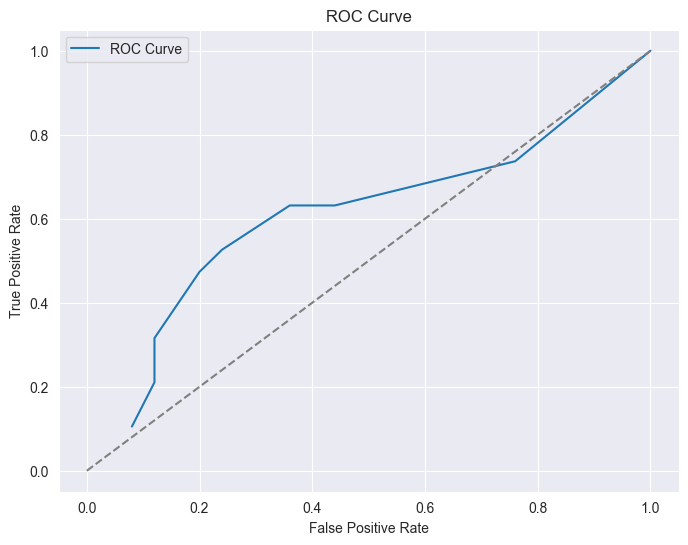

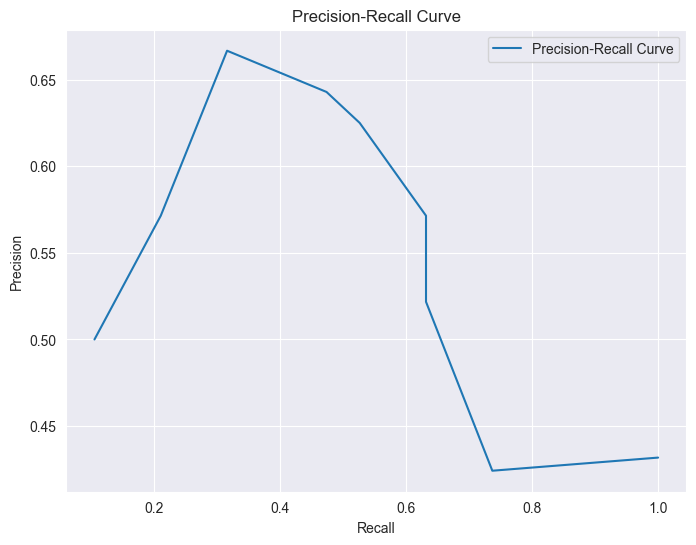

In [660]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_list, tpr_list, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_list, precision_list, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Вычислим площадь под кривой ROC и PR:

In [661]:
# Calculate and print AUC-ROC
auc_roc = abs(calculate_auc(fpr_list, tpr_list))
print(f"AUC-ROC: {auc_roc:.6f}")
# Calculate and print AUC-PR
auc_pr = abs(calculate_auc(recall_list, precision_list))
print(f"AUC-PR: {auc_pr:.6f}")


AUC-ROC: 0.605263
AUC-PR: 0.483700
